# Yelp Reviews: Polarity on Reviews - LightGBM GPU
## Optuna Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM


In [ ]:
# Clone lightGBM
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 27556, done.
remote: Counting objects: 100% (3712/3712), done.
remote: Compressing objects: 100% (379/379), done.
remote: Total 27556 (delta 3496), reused 3382 (delta 3326), pack-reused 23844
Receiving objects: 100% (27556/27556), 19.67 MiB | 6.90 MiB/s, done.
Resolving deltas: 100% (20445/20445), done.
Checking out files: 100% (521/521), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/external_libs/compute'...
remote: Enum

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/

!mkdir build

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM


In [ ]:
# Compile
!cmake -DUSE_GPU=1 
!make -j$(nproc)

CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.


-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found ver

In [ ]:
# Install needed packages
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools numpy pandas scikit-learn sklearn joblib optuna gensim==3.8.3 datetime plotly matplotlib seaborn -U

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libpython-all-dev python-all python-all-dev python-asn1crypto
  python-cffi-backend python-crypto python-cryptography python-dbus
  python-enum34 python-gi python-idna python-ipaddress python-keyring
  python-keyrings.alt python-pip-whl python-pkg-resources python-secretstorage
  python-setuptools python-six python-wheel python-xdg
Suggested packages:
  python-crypto-doc python-cryptography-doc python-cryptography-vectors
  python-dbus-dbg python-dbus-doc python-enum34-doc python-gi-cairo
  gnome-keyring libkf5wallet-bin gir1.2-gnomekeyring-1.0 python-fs
  python-gdata python-keyczar python-secretstorage-doc python-setuptools-doc
The following NEW packages will be installed:
  libpython-all-dev pytho

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/python-package/

# Compile for GPU
!sudo python3 setup.py install --precompile --gpu

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/python-package
running install
/usr/local/lib/python3.7/dist-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
running build
running build_py
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
copying lightgbm/dask.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/depe

In [ ]:
import os
import random
import numpy as np
import warnings
import pandas as pd
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import optuna
from optuna import Trial
from sklearn.metrics import log_loss, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score classification_report, confusion_matrix
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
my_dpi = 96
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Wed Apr 20 12:49:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|            

In [ ]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_sentimentNegPos_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (829874, 3)


cleanReview sentiment  \
index                                                                
1      [order, chicken, finger, sub, honey, mustard, ...  Negative   
3      [dedicated, loving, memory, gary, feldman, gre...  Negative   
12     [absolutely, horrible, thought, would, order, ...  Negative   
15     [found, better, chicken, finger, know, inside,...  Negative   
20     [amazing, everything, tried, disappoint, chick...  Negative   

       stars_reviews  
index                 
1                3.0  
3                5.0  
12               1.0  
15               4.0  
20               5.0

In [ ]:
# Examine how star reviews pairs with sentiment polarity
print(df[['stars_reviews', 'sentiment']].value_counts())

stars_reviews  sentiment
5.0            Positive     278011
1.0            Negative     231245
4.0            Positive     104585
2.0            Negative      90320
3.0            Negative      44097
4.0            Negative      26276
5.0            Negative      22999
3.0            Positive      22096
2.0            Positive       6690
1.0            Positive       3555
dtype: int64


In [ ]:
# Process format of reviews for word2vec
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

cleanReview sentiment  \
index                                                                
1      ["order", "chicken", "finger", "sub", "honey",...  Negative   
3      ["dedicated", "loving", "memory", "gary", "fel...  Negative   
12     ["absolutely", "horrible", "thought", "would",...  Negative   
15     ["found", "better", "chicken", "finger", "know...  Negative   
20     ["amazing", "everything", "tried", "disappoint...  Negative   

       stars_reviews  
index                 
1                3.0  
3                5.0  
12               1.0  
15               4.0  
20               5.0

In [ ]:
# Recode to binary
df['sentiment'].mask(df['sentiment'] == 'Negative', 0, inplace=True)
df['sentiment'].mask(df['sentiment'] == 'Positive', 1, inplace=True)

print('Number of reviews per group:')
df[['sentiment']].value_counts() 

Number of reviews per group:


sentiment
0            414937
1            414937
dtype: int64

In [ ]:
# Set up label and features
df['sentiment'] = df['sentiment'].astype('int')
label = df[['sentiment']]
features = df.cleanReview

## Word2vec - Sentiment: 50 epochs

In [ ]:
# Define parameters for Word2Vec model
model = Word2Vec(min_count=1, window=5, size=20, workers=cores)

In [ ]:
# Build vocab for model
print('Time to build vocab:', end=' ')
start = time.time()
model.build_vocab(features)
end = time.time()
print(round(end-start, 2), 'seconds')

Time to build vocab: 38.54 seconds


In [ ]:
# Length of vocab
vocab_len = len(model.wv.vocab)
print('Number words in the dictionary:', vocab_len)

Number words in the dictionary: 205415


In [ ]:
# Generate Word2Vec Word Embeddings
print('Time to train model:', end=' ')
start = time.time()
model.train(features, total_examples=model.corpus_count, epochs=50, 
            report_delay=1)
end = time.time()
print(round(end-start, 2), 'seconds')

Time to train model: 1148.49 seconds


In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Save the model
wv = model.wv
model.wv.save_word2vec_format('gensim_w2vModel_sentPosNeg_50epochs.bin', 
                              binary=True)

In [ ]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for text. 
    The transform function generates mean vectors in model pipelines.
    The class has both fit & transform functions for use in a sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        # If using GloVe, the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        # Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Implement a fit method required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        Generates a w2v vector for a set of tokens by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])
pl

Pipeline for Word2Vec:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7fa85472a390>)])

In [ ]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value)

    # Vectorize
    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    # Fit model
    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])
    run_time = timer() - start

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  

    return np.mean(cv_scores)       

### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_PKL/

In [ ]:
def lgb_hpo(trial):

    """
    Objective function to tune a `LGBMClassifier` model.
    """
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_sentPol.pkl')

    # Define parameter grid
    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=20),
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1e-1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1e-1,  log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500, 
                                               step=10),       
        'verbosity': -1}
    
    # Define model
    model = LGBMClassifier(**params_lgb_optuna, early_stopping_rounds=150)

    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('lightGBM_Optuna_100_GPU_sentPol.pkl'):
    study = joblib.load('lightGBM_Optuna_100_GPU_sentPol.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(lgb_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Start Time           2022-04-20 01:02:17.559725
[LightGBM] [Warning] lambda_l2 is set=2.3225869401298737e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3225869401298737e-08
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=0.09922728005626472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09922728005626472
[LightGBM] [Warning] min_gain_to_split is set=2.5221405638311083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5221405638311083
- Validation logloss: 0.6926908270223606
- Validation logloss: 0.12210959206572802
- Validation logloss: 0.3167348830655166
- Validation logloss: 0.6924113021812013
- Validation logloss: 0.537312476837933
- Validation logloss: 0.6894294404354734
- Validation logloss: 0.120104

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/trialOptions/

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_bagging_freq': 'bagging_freq'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree': 'colsample_bytree'}, 
                 inplace=True)
trials_df.rename(columns={'params_lambda_l1': 'lambda_l1'}, inplace=True)
trials_df.rename(columns={'params_lambda_l2': 'lambda_l2'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_depth': 'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_samples': 'min_child_samples'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_gain_to_split': 'min_gain_to_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_estimators': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_num_leaves': 'num_leaves'}, inplace=True)
trials_df.rename(columns={'params_subsample': 'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
trials_df = trials_df[trials_df['logloss'].notna()]
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('lightGBM_Optuna_100_GPU_sentPol.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
84         84  0.113741 2022-04-20 03:20:15.078784 2022-04-20 03:22:11.789091   
83         83  0.113819 2022-04-20 03:18:13.698845 2022-04-20 03:20:15.078641   
86         86  0.113837 2022-04-20 03:24:09.680177 2022-04-20 03:26:07.199001   
91         91  0.113933 2022-04-20 03:33:49.119155 2022-04-20 03:35:46.928264   
85         85  0.113964 2022-04-20 03:22:11.789230 2022-04-20 03:24:09.680038   
..        ...       ...                        ...                        ...   
38         38  0.689831 2022-04-20 01:58:21.856897 2022-04-20 01:59:58.189402   
99         99  0.691401 2022-04-20 03:48:55.241513 2022-04-20 03:50:49.263980   
3           3  0.692411 2022-04-20 01:07:10.605335 2022-04-20 01:08:49.420329   
0           0  0.692691 2022-04-20 01:02:17.561725 2022-04-20 01:04:15.120182   
36         36  0.692715 2022-04-20 01:55:12.493967 2022-04-20 01:56:57.299545   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_Explanations/

In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_lightGBM_Optuna_100_GPU_sentPol.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_lightGBM_Optuna_100_GPU_sentPol.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_lightGBM_Optuna_100_GPU_sentPol.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['num_leaves', 
                                                       'max_depth', 
                                                       'subsample', 
                                                       'learning_rate'])
py.plot(fig, filename='contour_lightGBM_Optuna_100_GPU_sentPol.html')
fig.show()

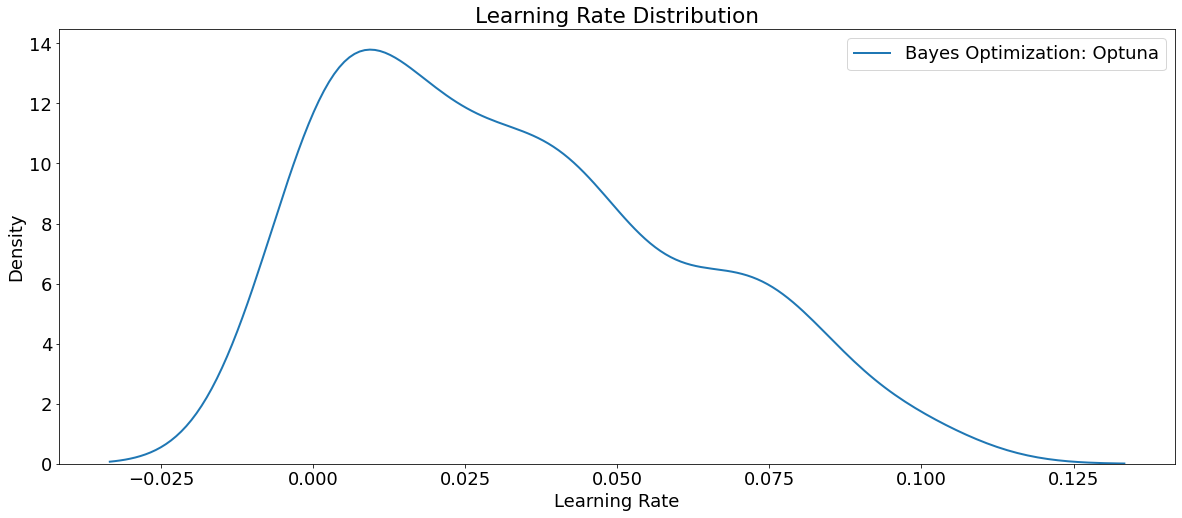

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); 
plt.title('Learning Rate Distribution');
plt.show()

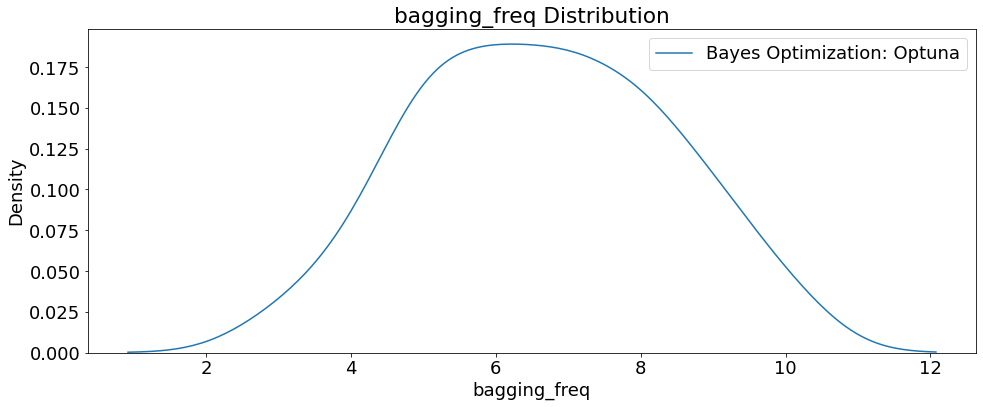

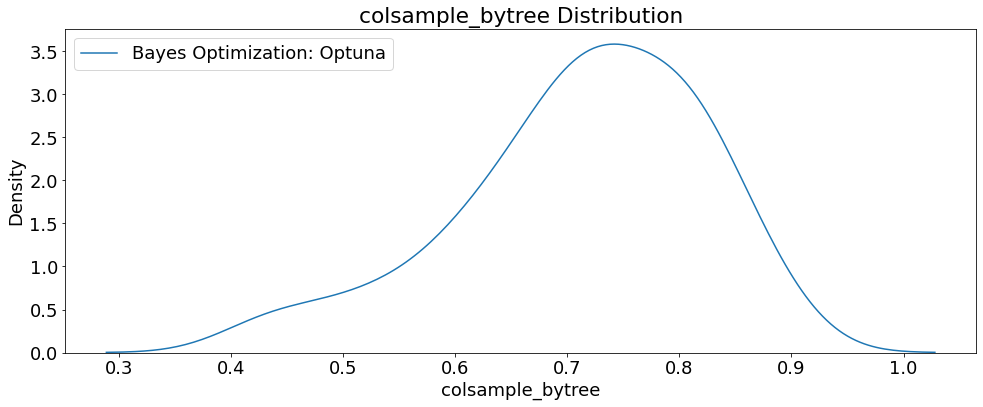

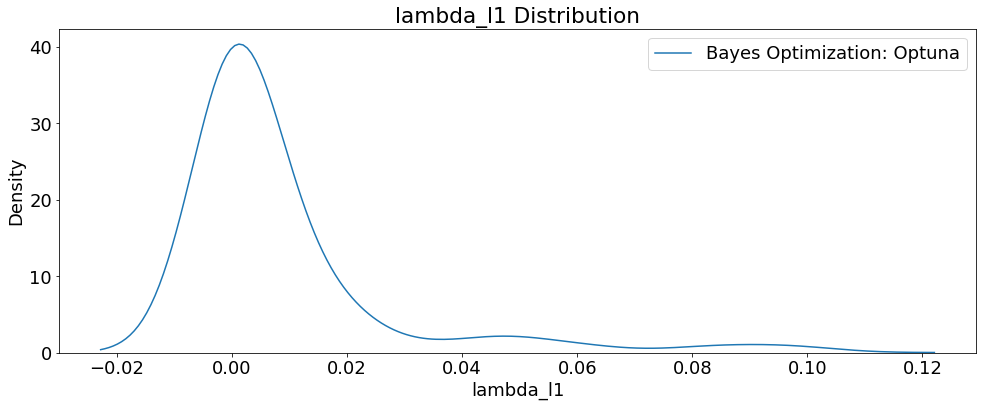

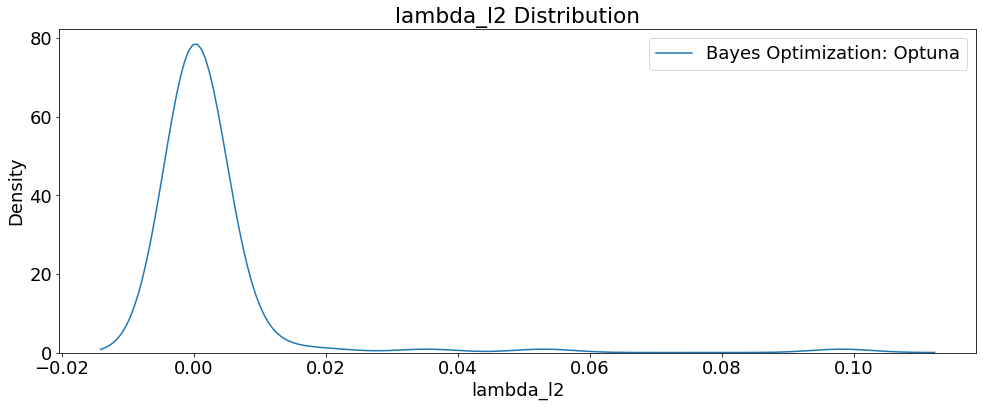

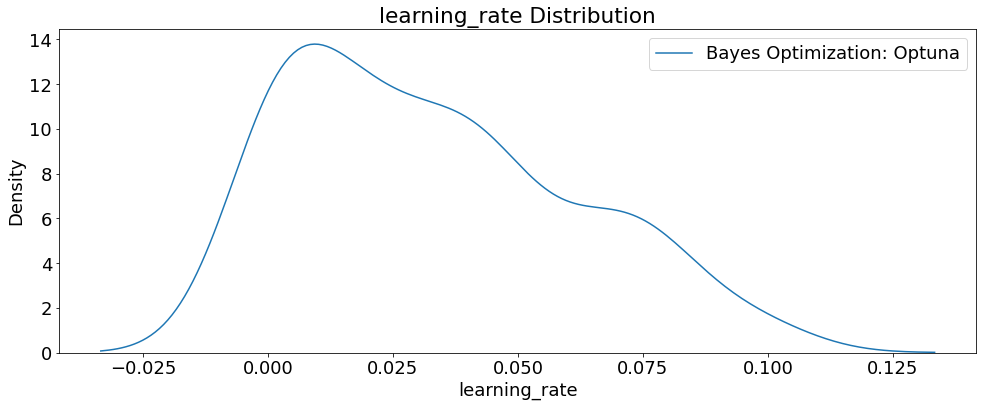

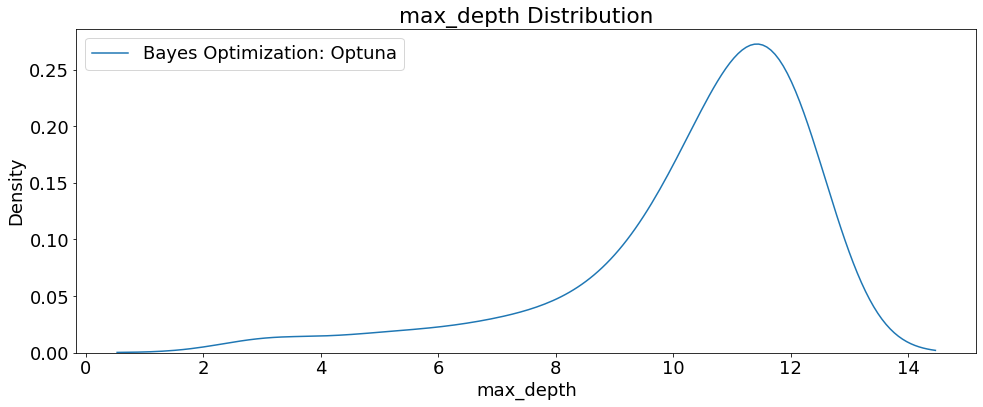

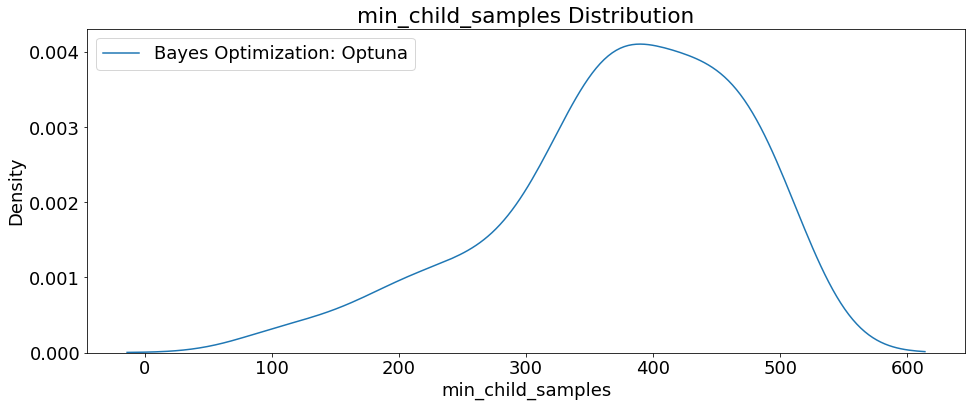

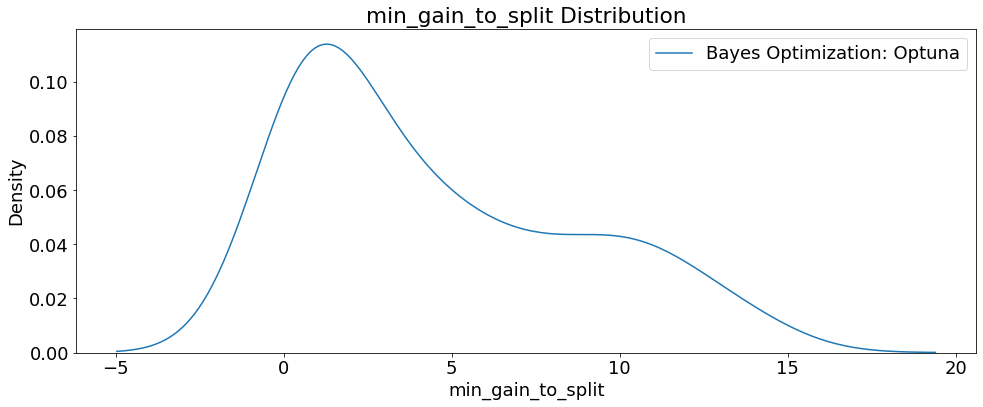

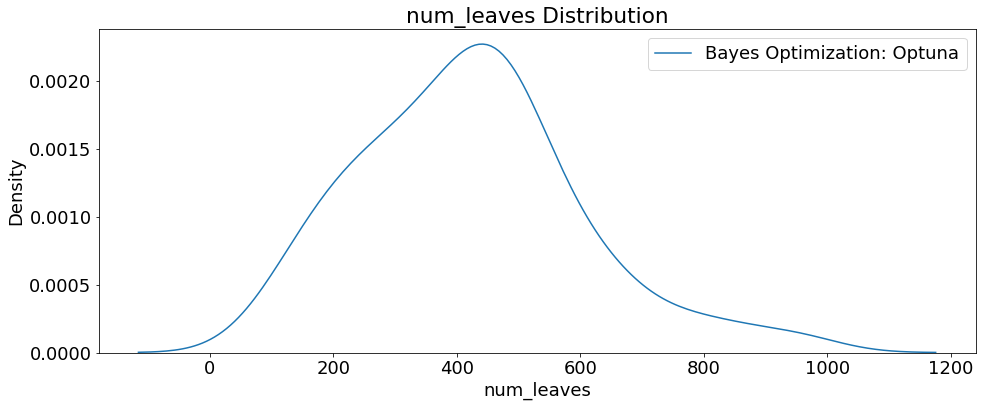

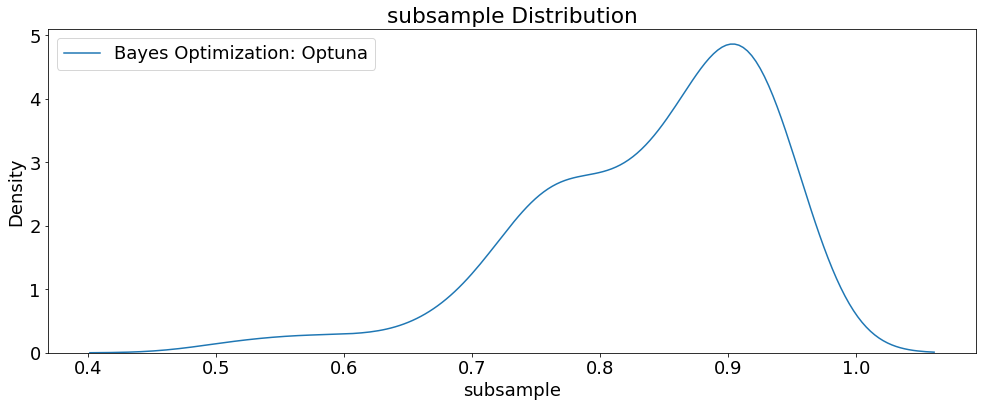

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

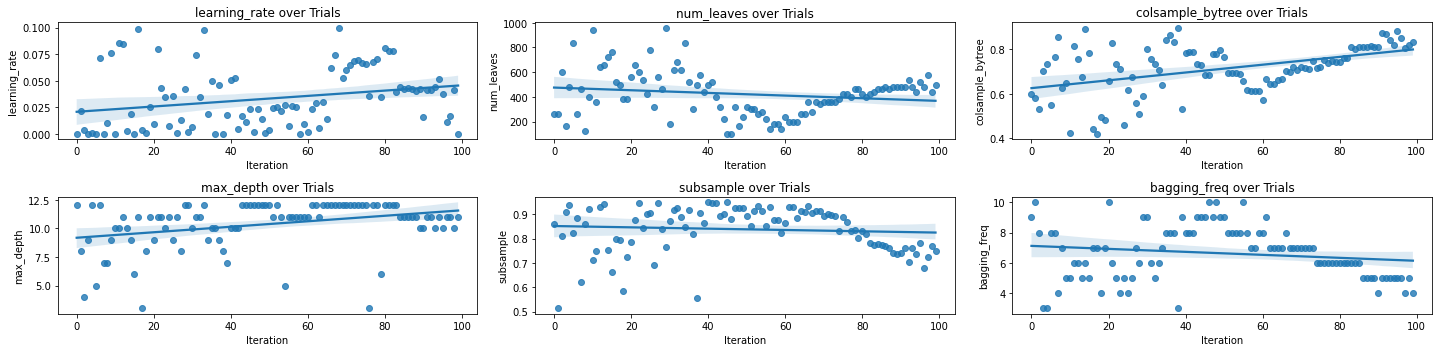

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(2, 3, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree', 
                         'max_depth', 'subsample', 'bagging_freq']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

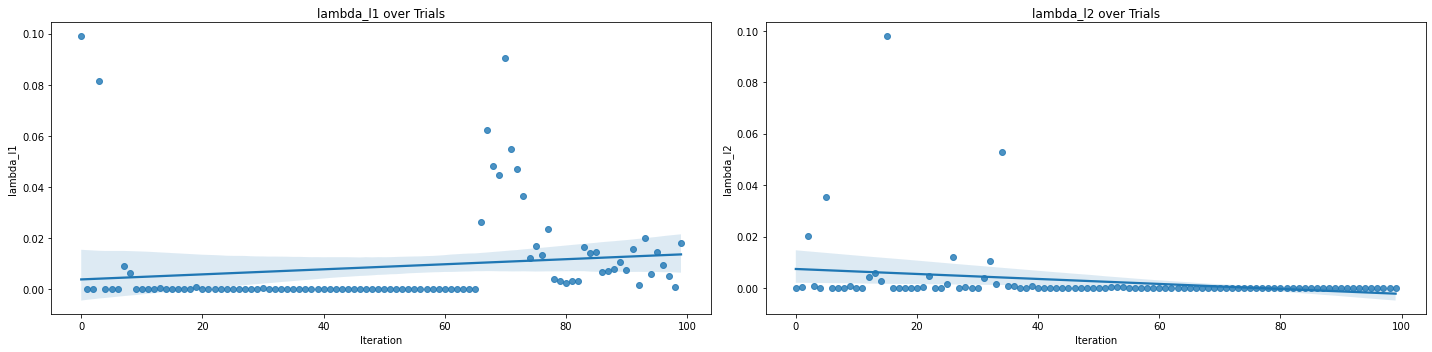

In [ ]:
# Scatterplot of regularization hyperparameters)
fig, axs = plt.subplots(1, 2, figsize=(20,5))
i = 0
for i, hpo in enumerate(['lambda_l1', 'lambda_l2']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_lightGBM_Optuna_100_GPU_sentPol.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_lightGBM_Optuna_100_GPU_sentPol.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['metric'] = 'binary_error'
params

{'bagging_freq': 6,
 'colsample_bytree': 0.8017664594837502,
 'lambda_l1': 0.014218104562665864,
 'lambda_l2': 2.8346318798717927e-08,
 'learning_rate': 0.04450091742132944,
 'max_depth': 11,
 'metric': 'binary_error',
 'min_child_samples': 370,
 'min_gain_to_split': 0.28239581298225364,
 'n_estimators': 450,
 'num_leaves': 460,
 'random_state': 42,
 'subsample': 0.7785234635839293}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_PKL/

In [ ]:
# Set target and features
label = df[['sentiment']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = LGBMClassifier(**params, verbosity=-1)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'lightGBM_HPO_Optuna_trials100_GPU_sentPol.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM_HPO_Optuna_trials100_GPU_sentPol.pkl')
# print(model)
# =============================================================================

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
print('Results from lightGBM HPO Optuna 100 GPU SentimentPolarity trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from lightGBM HPO Optuna 100 GPU SentimentPolarity trials:


Classification Report: Train
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    331950
           1       0.97      0.97      0.97    331949

    accuracy                           0.97    663899
   macro avg       0.97      0.97      0.97    663899
weighted avg       0.97      0.97      0.97    663899



Confusion matrix: Train
[[322611   9339]
 [ 10318 321631]]


Classification Report: Test
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     82987
           1       0.96      0.96      0.96     82988

    accuracy                           0.96    165975
   macro avg       0.96      0.96      0.96    165975
weighted avg       0.96      0.96      0.96    165975



Confusion matrix: Test
[[79685  3302]
 [ 3679 79309]]


Accuracy score: train: 0.970, test: 0.958
Precision score: train: 0.972, test: 0.960
Recall score: 

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.95794 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    84
logloss                                0.113741
datetime_start       2022-04-20 03:20:15.078784
datetime_complete    2022-04-20 03:22:11.789091
duration                 0 days 00:01:56.710307
bagging_freq                                  6
colsample_bytree                       0.801766
lambda_l1                              0.014218
lambda_l2                                   0.0
learning_rate                          0.044501
max_depth                                    11
min_child_samples                           370
min_gain_to_split                      0.282396
n_estimators                                450
num_leaves                                  460
subsample                              0.778523
state                                  COMPLETE
Name: 0, dtype: object


## Word2vec - Reviews: 50epochs

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
  # Load model
word2vec_path = 'gensim_w2vModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv
pl = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_PKL/

In [ ]:
def lgb_hpo(trial):
    """
    Objective function to tune a `LGBMClassifier` model.
    """
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.pkl')

    # Define parameter grid
    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=20),
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1e-1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1e-1,  log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500, 
                                               step=10),       
        'verbosity': -1}
    
    # Define model
    model = LGBMClassifier(**params_lgb_optuna, early_stopping_rounds=150)

    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.pkl'):
    study = joblib.load('lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(lgb_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Start Time           2022-05-14 14:13:57.011785
[LightGBM] [Warning] lambda_l2 is set=4.999447538508179e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.999447538508179e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=0.0001484292741448731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001484292741448731
[LightGBM] [Warning] min_gain_to_split is set=4.493516448079726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.493516448079726
- Validation logloss: 0.2795612525955914
- Validation logloss: 0.6878158823790498
- Validation logloss: 0.18122612741879876
- Validation logloss: 0.20811512057821
- Validation logloss: 0.6792529992489712
- Validation logloss: 0.4761709820964655
- Validation logloss: 0.6928661

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/trialOptions/

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_bagging_freq': 'bagging_freq'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree': 'colsample_bytree'}, 
                 inplace=True)
trials_df.rename(columns={'params_lambda_l1': 'lambda_l1'}, inplace=True)
trials_df.rename(columns={'params_lambda_l2': 'lambda_l2'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_depth': 'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_samples': 'min_child_samples'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_gain_to_split': 'min_gain_to_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_estimators': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_num_leaves': 'num_leaves'}, inplace=True)
trials_df.rename(columns={'params_subsample': 'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
trials_df = trials_df[trials_df['logloss'].notna()]
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.csv', 
                 index=False)

    iteration   logloss             datetime_start          datetime_complete  \
64         64  0.156697 2022-05-14 16:19:22.200275 2022-05-14 16:21:20.850815   
32         32  0.156775 2022-05-14 15:16:24.446051 2022-05-14 15:18:44.092495   
31         31  0.156805 2022-05-14 15:14:04.600215 2022-05-14 15:16:24.445913   
8           8  0.156833 2022-05-14 14:27:31.005072 2022-05-14 14:29:38.166842   
41         41  0.156845 2022-05-14 15:34:48.033415 2022-05-14 15:36:59.764546   
..        ...       ...                        ...                        ...   
9           9  0.688271 2022-05-14 14:29:38.166956 2022-05-14 14:31:08.147068   
33         33  0.690566 2022-05-14 15:18:44.092624 2022-05-14 15:21:12.160115   
18         18  0.692085 2022-05-14 14:46:07.810716 2022-05-14 14:48:10.132489   
87         87  0.692687 2022-05-14 17:01:35.436010 2022-05-14 17:03:34.308213   
6           6  0.692866 2022-05-14 14:24:09.798452 2022-05-14 14:25:44.332003   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_Explanations/

In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['num_leaves', 
                                                       'max_depth', 
                                                       'subsample', 
                                                       'learning_rate'])
py.plot(fig, filename='contour_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

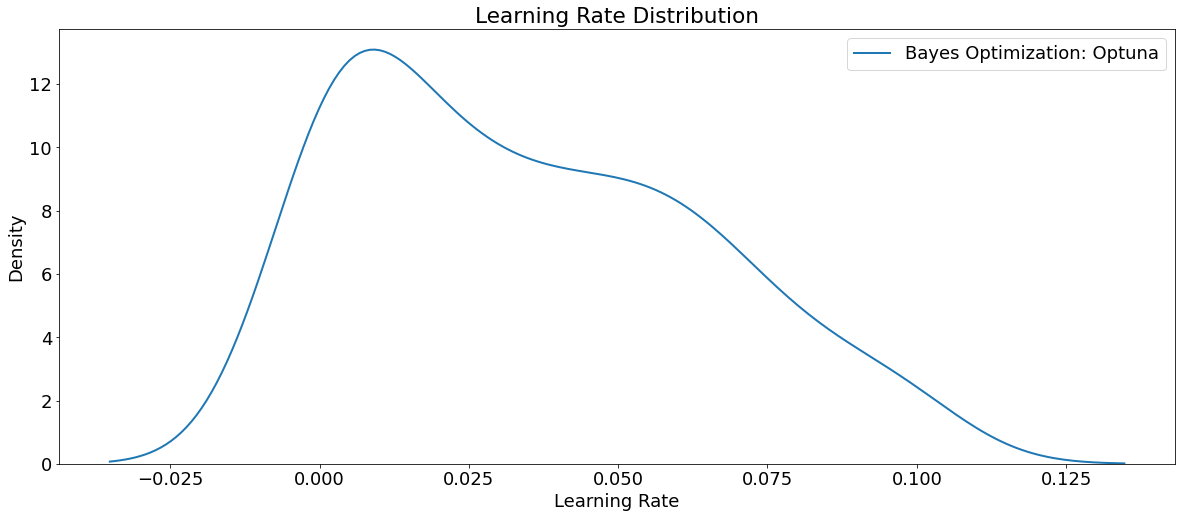

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); 
plt.title('Learning Rate Distribution');
plt.show()

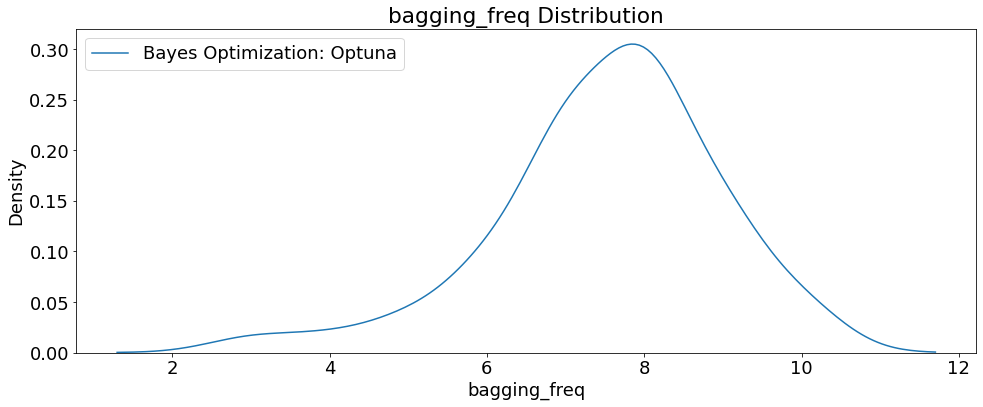

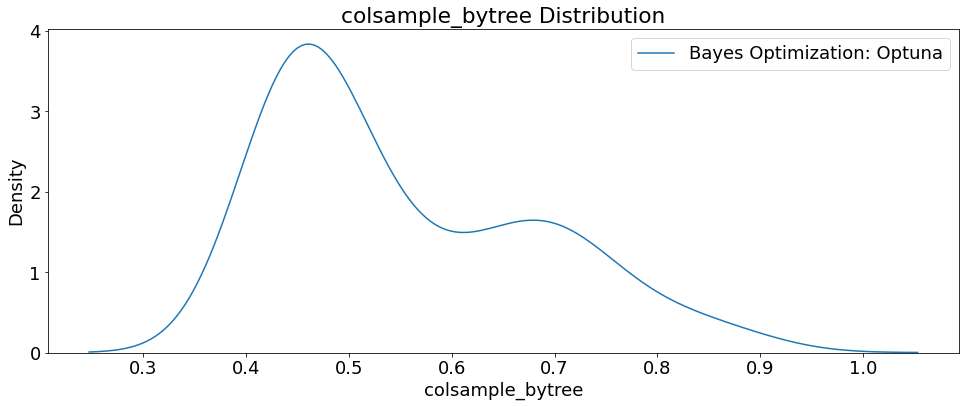

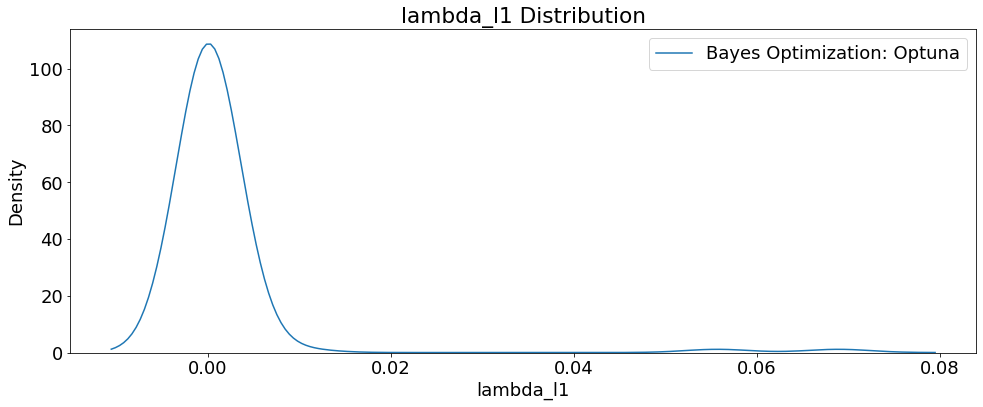

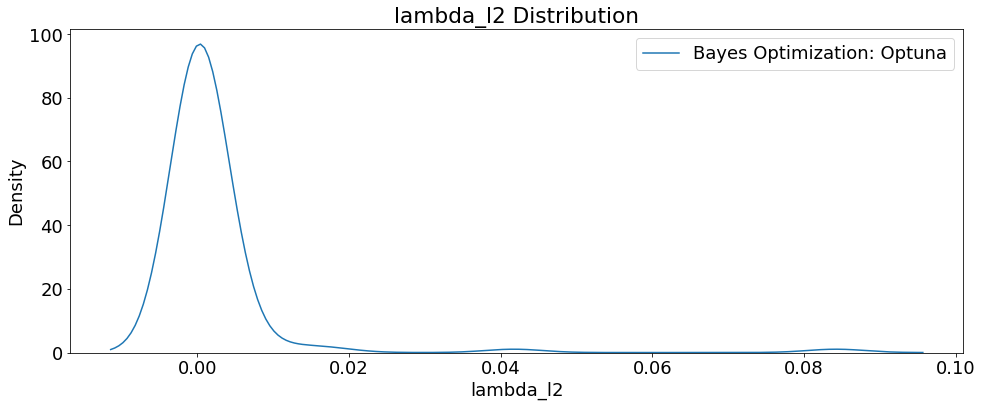

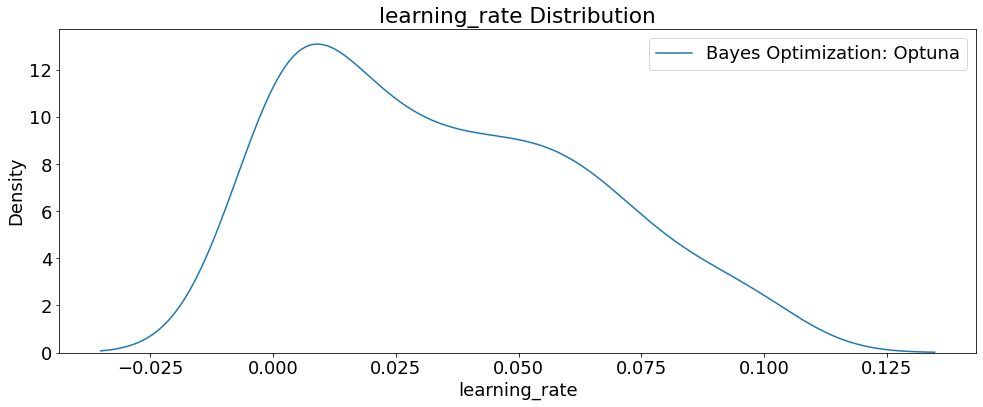

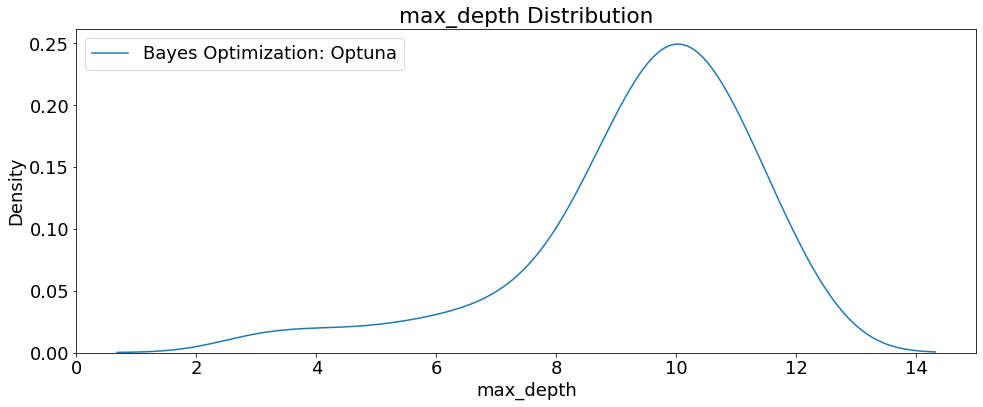

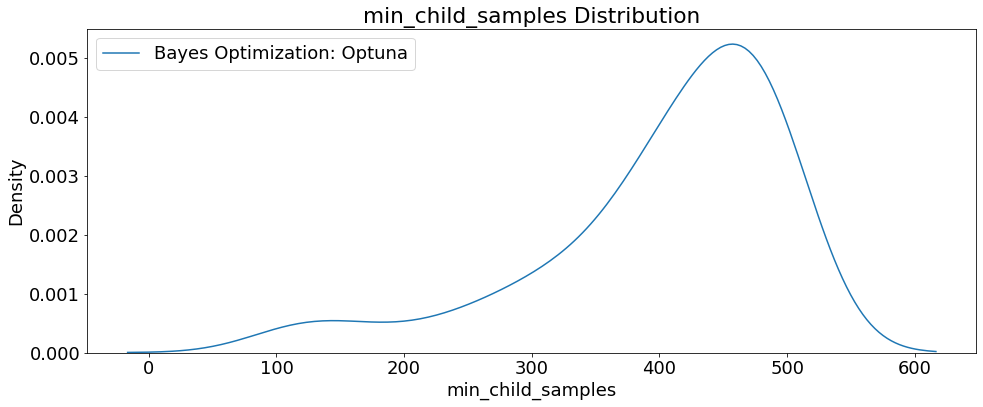

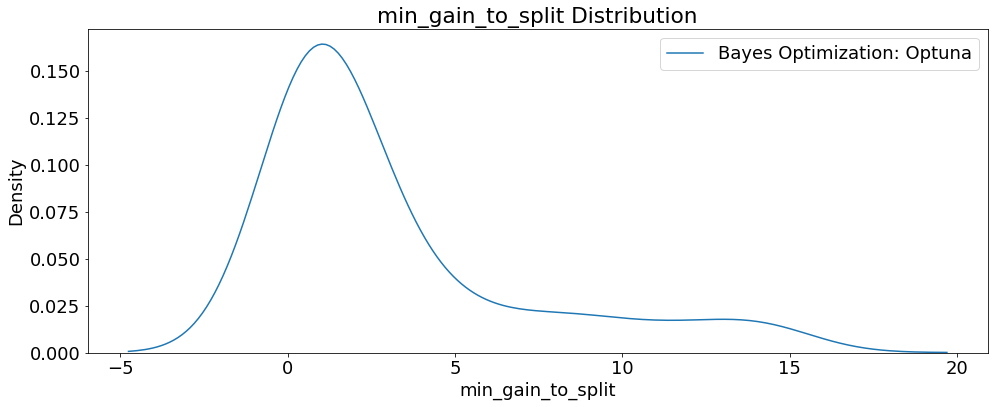

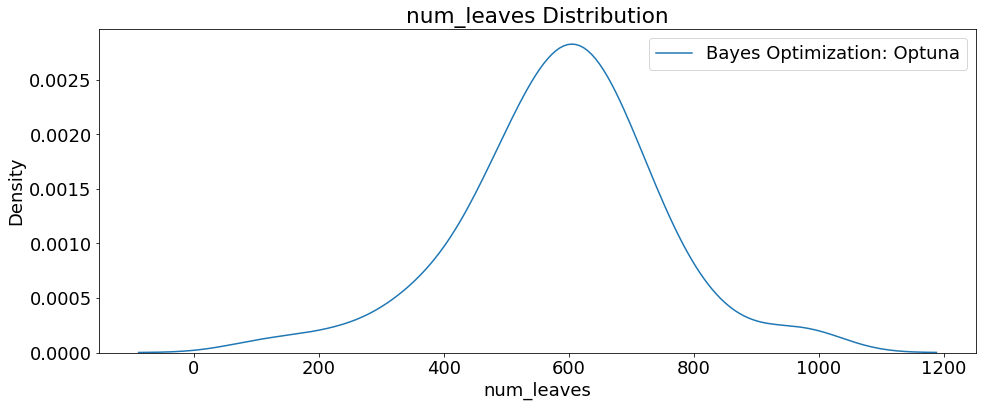

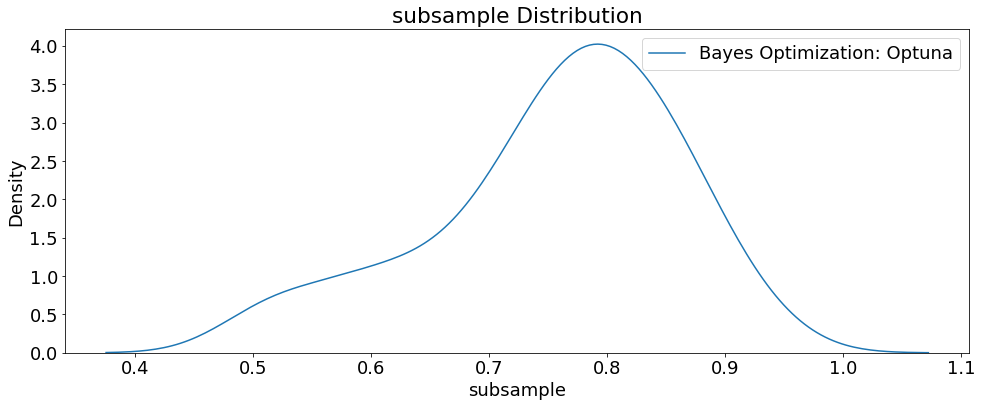

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

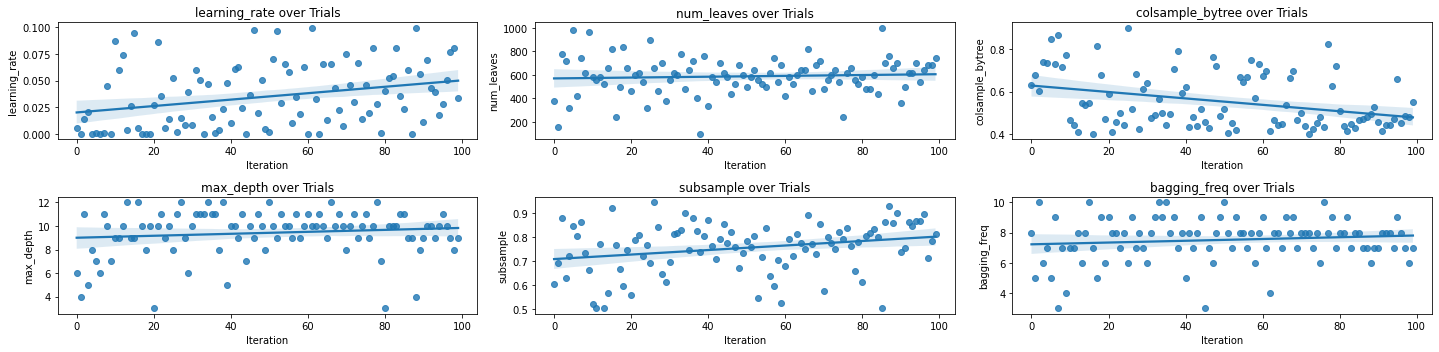

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(2, 3, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree', 
                         'max_depth', 'subsample', 'bagging_freq']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

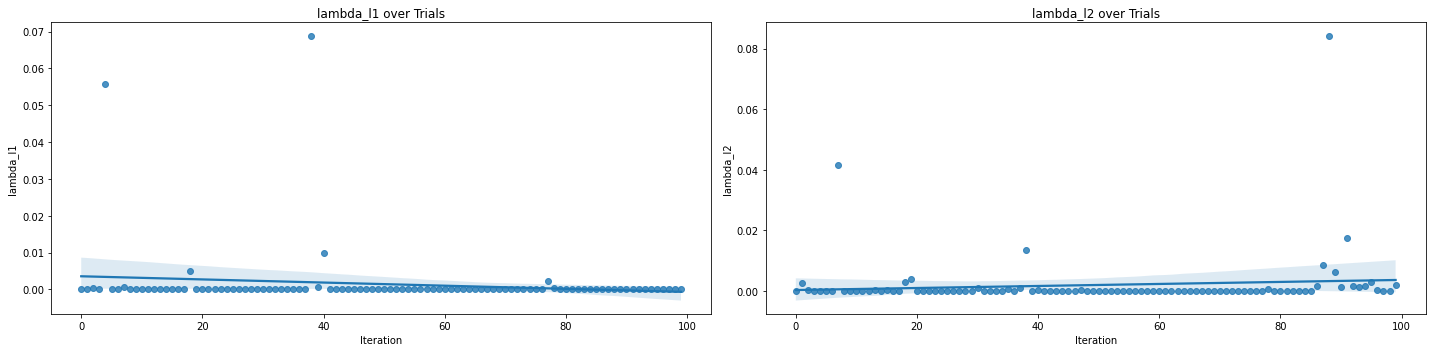

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(20,5))
i = 0
for i, hpo in enumerate(['lambda_l1', 'lambda_l2']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_lightGBM_Optuna_100_GPU_sentPol_w2vReviewStars.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['metric'] = 'binary_error'
params

{'bagging_freq': 8,
 'colsample_bytree': 0.4421328088439629,
 'lambda_l1': 1.8108593985768235e-08,
 'lambda_l2': 1.3983527803690125e-06,
 'learning_rate': 0.06531163131919056,
 'max_depth': 10,
 'metric': 'binary_error',
 'min_child_samples': 330,
 'min_gain_to_split': 0.41480137178119253,
 'n_estimators': 500,
 'num_leaves': 640,
 'random_state': 42,
 'subsample': 0.7760295887433482}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_PKL/

In [ ]:
# Set up target abd features
label = df[['sentiment']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = LGBMClassifier(**params, verbosity=-1)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'lightGBM_HPO_Optuna_trials100_GPU_sentPol_w2vReviewStars.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM_HPO_Optuna_trials100_GPU_sentPol_w2vReviewStars.pkl')
# print(model)
# =============================================================================

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
print('Results from lightGBM HPO Optuna 100 GPU SentimentPolarity trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from lightGBM HPO Optuna 100 GPU SentimentPolarity trials:


Classification Report: Train
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    331949
           1       0.96      0.96      0.96    331950

    accuracy                           0.96    663899
   macro avg       0.96      0.96      0.96    663899
weighted avg       0.96      0.96      0.96    663899



Confusion matrix: Train
[[319265  12684]
 [ 13372 318578]]


Classification Report: Test
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     82988
           1       0.94      0.94      0.94     82987

    accuracy                           0.94    165975
   macro avg       0.94      0.94      0.94    165975
weighted avg       0.94      0.94      0.94    165975



Confusion matrix: Test
[[78063  4925]
 [ 5096 77891]]


Accuracy score: train: 0.961, test: 0.940
Precision score: train: 0.962, test: 0.941
Recall score: 

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93962 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    64
logloss                                0.156697
datetime_start       2022-05-14 16:19:22.200275
datetime_complete    2022-05-14 16:21:20.850815
duration                 0 days 00:01:58.650540
bagging_freq                                  8
colsample_bytree                       0.442133
lambda_l1                                   0.0
lambda_l2                              0.000001
learning_rate                          0.065312
max_depth                                    10
min_child_samples                           330
min_gain_to_split                      0.414801
n_estimators                                500
num_leaves                                  640
subsample                               0.77603
state                                  COMPLETE
Name: 0, dtype: object


## GloVe 6B 50d - Sentiment: 50 epochs

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Load model
word2vec_path = 'glove.6B.50dModel_sentPoSNeg_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv
pl = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_PKL/

In [ ]:
def lgb_hpo(trial):
    """
    Objective function to tune a `lightGBMClassifier` model.
    """
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_glove_sentPol.pkl')

    # Define parameter grid
    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=20),
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1e-1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1e-1,  log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500, 
                                               step=10),       
        'verbosity': -1}
    
    # Define model
    model = LGBMClassifier(**params_lgb_optuna, early_stopping_rounds=150)

    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('lightGBM_Optuna_100_GPU_glove_sentPol.pkl'):
    study = joblib.load('lightGBM_Optuna_100_GPU_glove_sentPol.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(lgb_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Start Time           2022-04-20 20:06:57.261649
[LightGBM] [Warning] lambda_l2 is set=2.1116059158280954e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1116059158280954e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=2.7933470777904995e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7933470777904995e-07
[LightGBM] [Warning] min_gain_to_split is set=2.356582380857741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.356582380857741
- Validation logloss: 0.6918089924013593
- Validation logloss: 0.6440579997408526
- Validation logloss: 0.12844964646722212
- Validation logloss: 0.6341918599263537
- Validation logloss: 0.2288563390442418
- Validation logloss: 0.6928094804385313
- Validation logloss: 0.6

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/trialOptions/

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_bagging_freq': 'bagging_freq'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree': 'colsample_bytree'}, 
                 inplace=True)
trials_df.rename(columns={'params_lambda_l1': 'lambda_l1'}, inplace=True)
trials_df.rename(columns={'params_lambda_l2': 'lambda_l2'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_depth': 'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_samples': 'min_child_samples'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_gain_to_split': 'min_gain_to_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_estimators': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_num_leaves': 'num_leaves'}, inplace=True)
trials_df.rename(columns={'params_subsample': 'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
trials_df = trials_df[trials_df['logloss'].notna()]
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('lightGBM_Optuna_100_GPU_glove_sentPol.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
96         96  0.112406 2022-04-20 22:44:16.498079 2022-04-20 22:46:11.233910   
97         97  0.112571 2022-04-20 22:46:11.234049 2022-04-20 22:48:06.943054   
90         90  0.112583 2022-04-20 22:32:24.757299 2022-04-20 22:34:17.783456   
98         98  0.112595 2022-04-20 22:48:06.943222 2022-04-20 22:50:01.593704   
88         88  0.112637 2022-04-20 22:28:25.788555 2022-04-20 22:30:20.560937   
..        ...       ...                        ...                        ...   
30         30  0.690501 2022-04-20 20:52:41.986771 2022-04-20 20:54:32.933190   
0           0  0.691809 2022-04-20 20:06:57.547904 2022-04-20 20:08:43.831749   
50         50  0.691943 2022-04-20 21:24:33.179259 2022-04-20 21:26:11.601263   
6           6  0.692564 2022-04-20 20:16:13.435144 2022-04-20 20:18:04.686339   
5           5  0.692809 2022-04-20 20:14:26.053115 2022-04-20 20:16:13.435025   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_Explanations/

In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_lightGBM_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_lightGBM_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_lightGBM_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['num_leaves', 
                                                       'max_depth', 
                                                       'subsample', 
                                                       'learning_rate'])
py.plot(fig, filename='contour_lightGBM_Optuna_100_GPU_glove_sentPol.html')
fig.show()

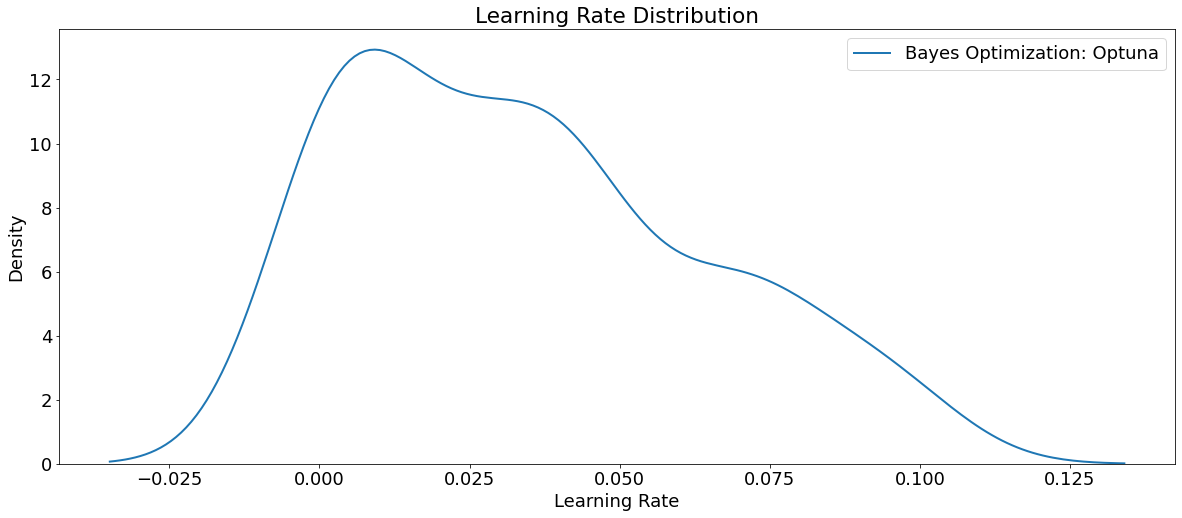

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); 
plt.title('Learning Rate Distribution');
plt.show()

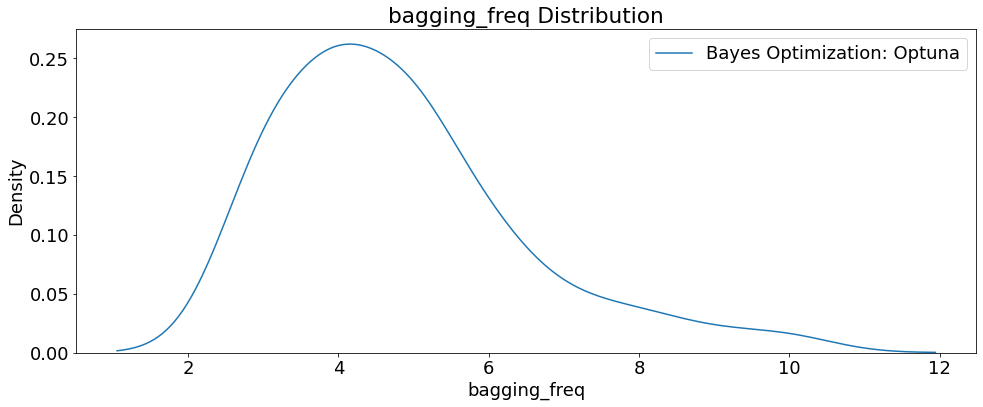

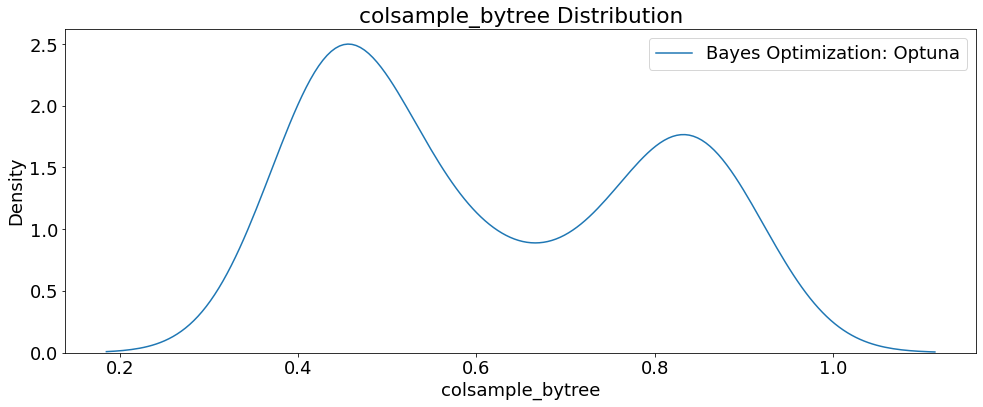

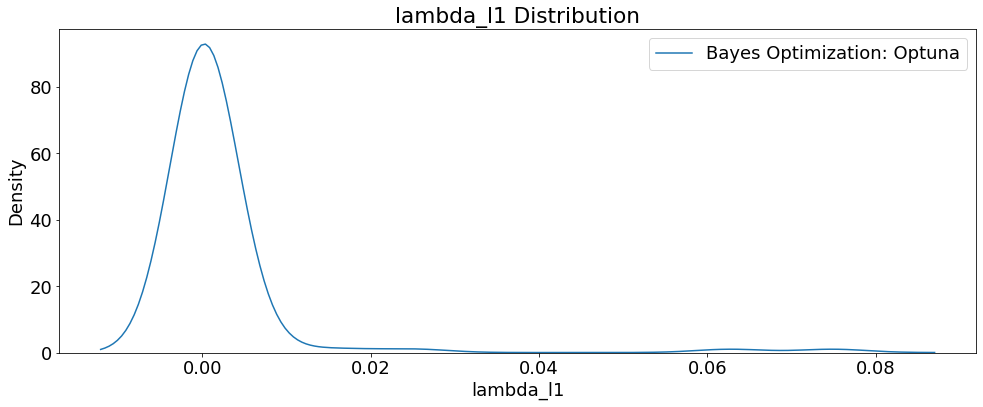

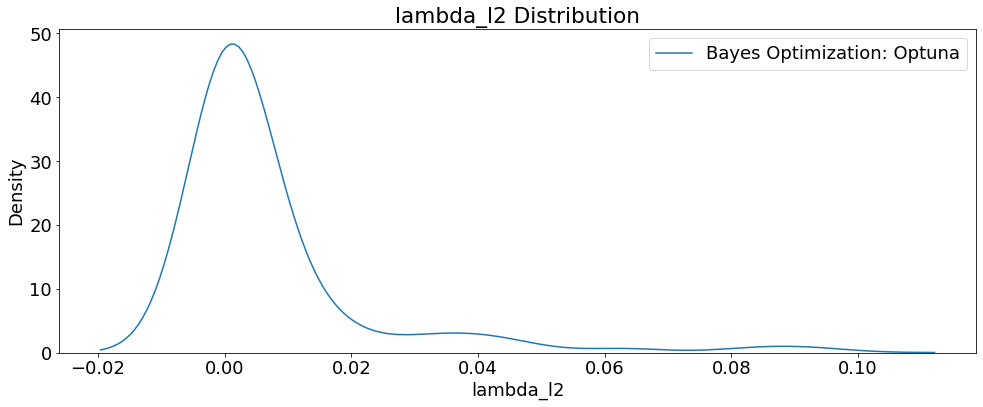

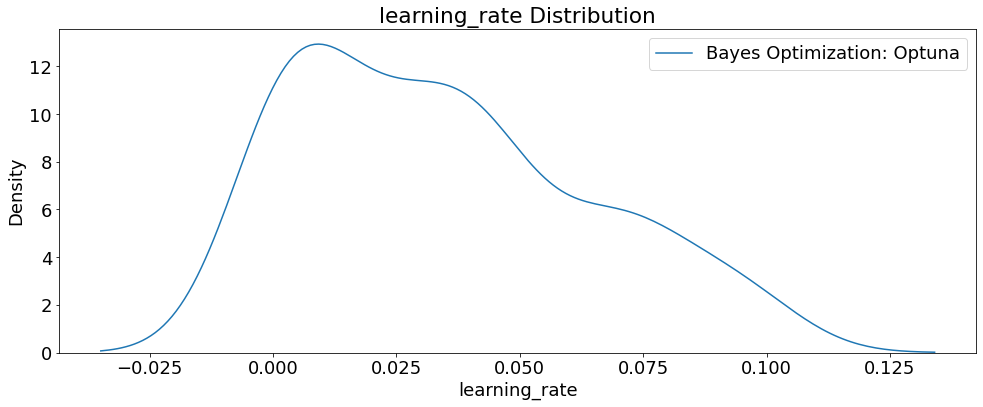

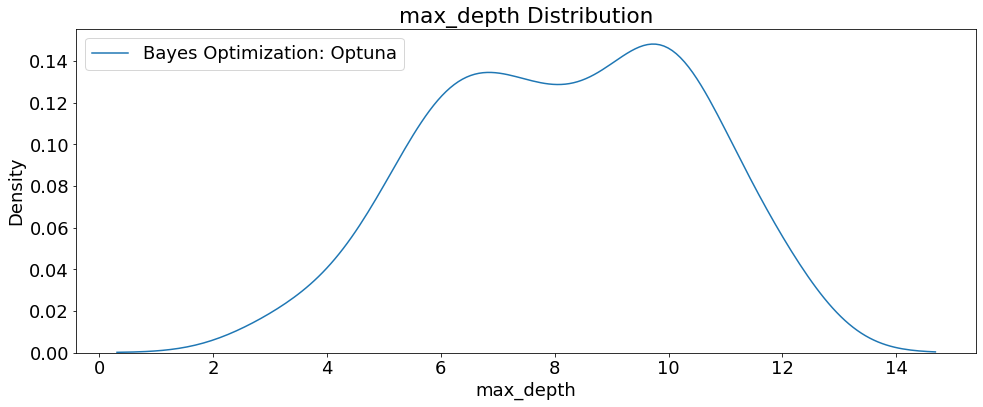

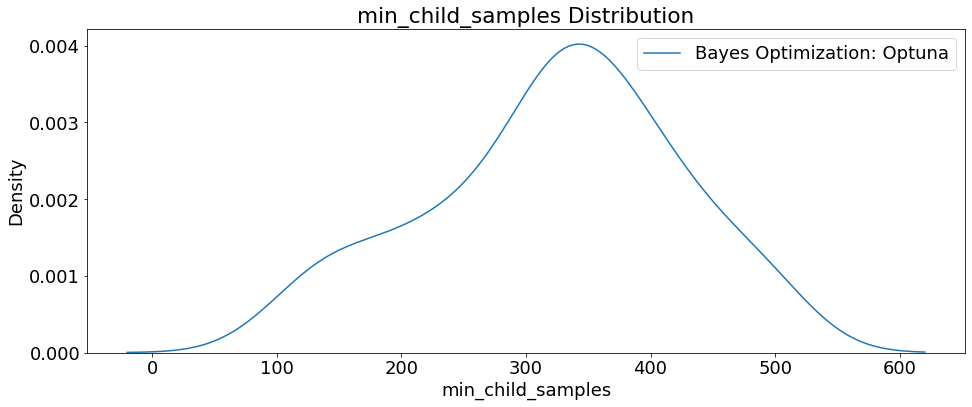

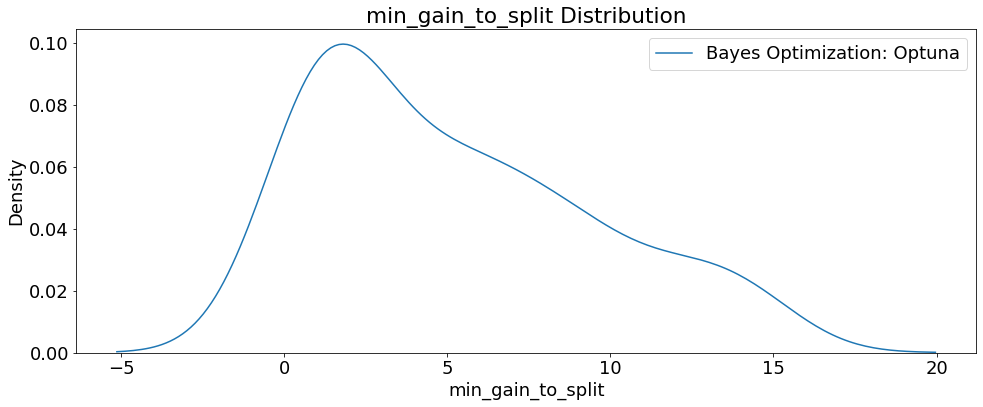

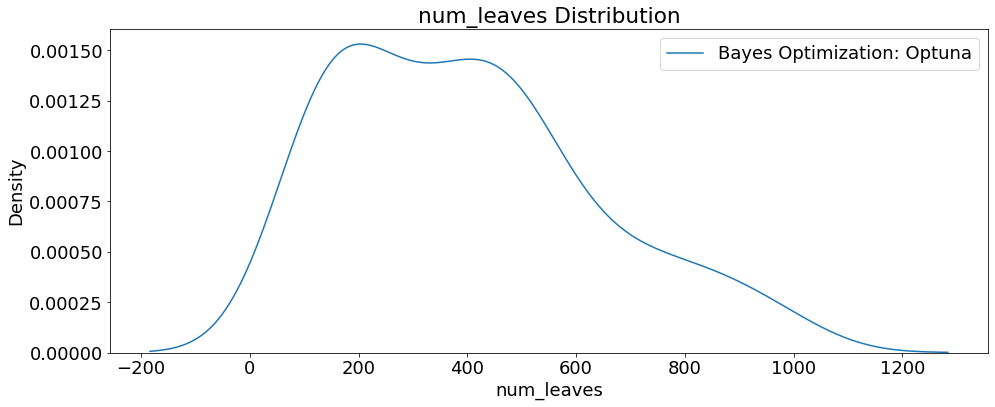

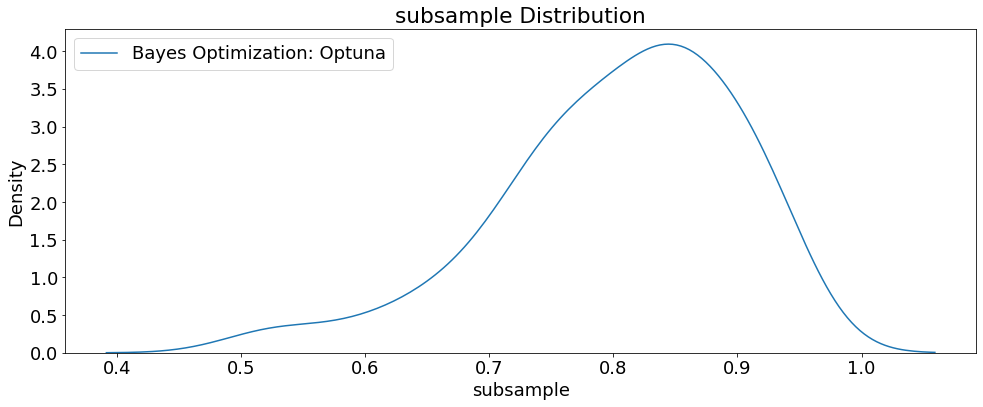

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

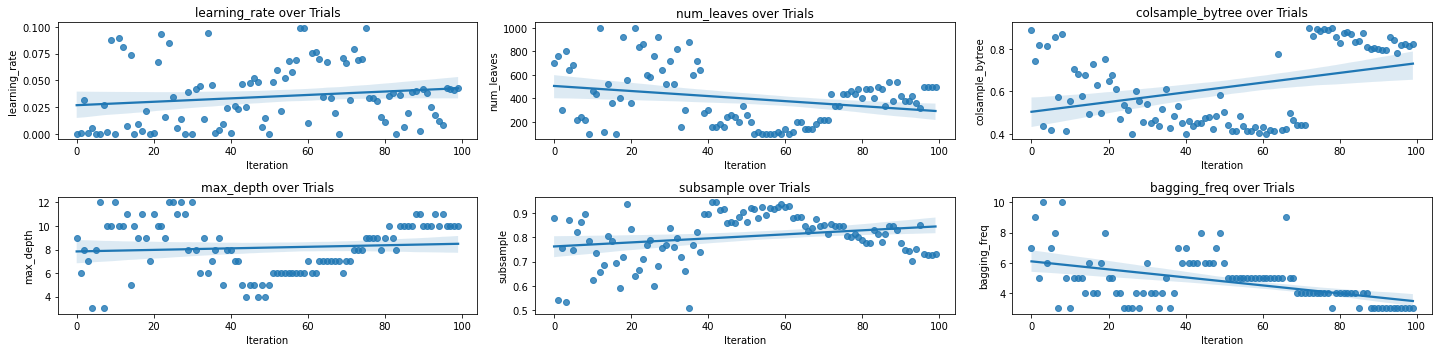

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(2, 3, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree', 
                         'max_depth', 'subsample', 'bagging_freq']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

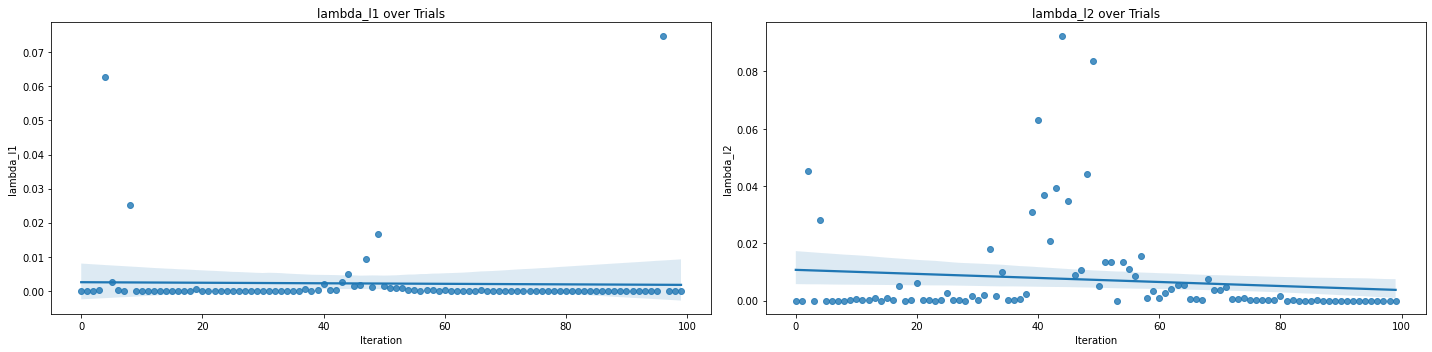

In [ ]:
# Scatterplot of regularization hyperparameters)
fig, axs = plt.subplots(1, 2, figsize=(20,5))
i = 0
for i, hpo in enumerate(['lambda_l1', 'lambda_l2']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_lightGBM_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_lightGBM_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['metric'] = 'binary_error'
params

{'bagging_freq': 3,
 'colsample_bytree': 0.8183595650027249,
 'lambda_l1': 0.07489870395947539,
 'lambda_l2': 3.816798720858926e-06,
 'learning_rate': 0.042611191588088515,
 'max_depth': 10,
 'metric': 'binary_error',
 'min_child_samples': 340,
 'min_gain_to_split': 1.2591202418818939,
 'n_estimators': 380,
 'num_leaves': 500,
 'random_state': 42,
 'subsample': 0.7318635934951965}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_PKL/

In [ ]:
# Set up label and features
label = df[['sentiment']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = LGBMClassifier(**params, verbosity=-1)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'lightGBM_HPO_Optuna_trials100_GPU_glove_sentPol.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM_HPO_Optuna_trials100_GPU_glove_sentPol.pkl')
# print(model)
# =============================================================================

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
print('Results from lightGBM HPO Optuna 100 GloVe GPU Sentiment Polarity trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from lightGBM HPO Optuna 100 GloVe GPU Sentiment Polarity trials:


Classification Report: Train
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    331949
           1       0.97      0.97      0.97    331950

    accuracy                           0.97    663899
   macro avg       0.97      0.97      0.97    663899
weighted avg       0.97      0.97      0.97    663899



Confusion matrix: Train
[[322130   9819]
 [ 11150 320800]]


Classification Report: Test
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     82988
           1       0.96      0.96      0.96     82987

    accuracy                           0.96    165975
   macro avg       0.96      0.96      0.96    165975
weighted avg       0.96      0.96      0.96    165975



Confusion matrix: Test
[[79690  3298]
 [ 3593 79394]]


Accuracy score: train: 0.968, test: 0.958
Precision score: train: 0.970, test: 0.960
Recall 

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.95848 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    96
logloss                                0.112406
datetime_start       2022-04-20 22:44:16.498079
datetime_complete    2022-04-20 22:46:11.233910
duration                 0 days 00:01:54.735831
bagging_freq                                  3
colsample_bytree                        0.81836
lambda_l1                              0.074899
lambda_l2                              0.000004
learning_rate                          0.042611
max_depth                                    10
min_child_samples                           340
min_gain_to_split                       1.25912
n_estimators                                380
num_leaves                                  500
subsample                              0.731864
state                                  COMPLETE
Name: 0, dtype: object


## GloVe 6B 300d - Sentiment: 50 epochs

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Load model
word2vec_path = 'glove.6B.300dModel_sentPosNeg_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
print('Pipeline for Word2Vec of GloVe:')
pl  = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])
pl

Pipeline for Word2Vec of GloVe:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7fb14bc0ad50>)])

### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_PKL/

In [ ]:
# Log in to wandb
wandb.login()

wandb_kwargs = {'project': 'YelpReviews_lightGBM_Optuna', 'entity': 'aschultz', 
                'group': 'optuna_lgb100gpu_SP_glove300d', 
                'save_code': 'False', 'notes': 'optuna_lgb100gpu_SP_glove300d'}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



In [ ]:
# Set up WB callbacks
@wandbc.track_in_wandb()

def lgb_hpo(trial):
    """
    Objective function to tune a `lightGBMClassifier` model.
    """
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_glove300d_sentPol.pkl')

    # Define parameter grid
    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=20),
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1e-1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1e-1,  log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500, 
                                               step=10),       
        'verbosity': -1}
    
    # Define model
    model = LGBMClassifier(**params_lgb_optuna, early_stopping_rounds=150)

    return train_model_for_study(features, label, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ExperimentalWarning:

track_in_wandb is experimental (supported from v3.0.0). The interface can change in the future.



In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('lightGBM_Optuna_100_GPU_glove300d_sentPol.pkl'):
    study = joblib.load('lightGBM_Optuna_100_GPU_glove300d_sentPol.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(lgb_hpo, n_trials=100, callbacks=[wandbc])

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Start Time           2022-09-10 04:28:41.089000
[LightGBM] [Warning] lambda_l2 is set=7.863369850608358e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.863369850608358e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=1.9415522228778534e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9415522228778534e-06
[LightGBM] [Warning] min_gain_to_split is set=10.609560176122002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.609560176122002
- Validation logloss: 0.14604651665611842


- Validation logloss: 0.11435444477586136


- Validation logloss: 0.1328674527629765


- Validation logloss: 0.4285482150000267


- Validation logloss: 0.12551054315126436


- Validation logloss: 0.11577895341545058


- Validation logloss: 0.11446877534797985


- Validation logloss: 0.11673737720050865


- Validation logloss: 0.12866482250126926


- Validation logloss: 0.1193612100178634


- Validation logloss: 0.11886518588738278


- Validation logloss: 0.11276000203277113


- Validation logloss: 0.11271834764502311


- Validation logloss: 0.1125604114731771


- Validation logloss: 0.11312466388820983


- Validation logloss: 0.11528793540130589


- Validation logloss: 0.2304745936603271


- Validation logloss: 0.11751769057640654


- Validation logloss: 0.11641347818209996


- Validation logloss: 0.1129021212860885


- Validation logloss: 0.11450452118990519


- Validation logloss: 0.11298668471499627


- Validation logloss: 0.1129230803354237


- Validation logloss: 0.11316820784442655


- Validation logloss: 0.11439670682841538


- Validation logloss: 0.11288218047421504


- Validation logloss: 0.11601230520684223


- Validation logloss: 0.11826765594753434


- Validation logloss: 0.11457083837591563


- Validation logloss: 0.11599008467216355


- Validation logloss: 0.1323416178981274


- Validation logloss: 0.11274972038913904


- Validation logloss: 0.11298618126452954


- Validation logloss: 0.11385286085754628


- Validation logloss: 0.11293738186201667


- Validation logloss: 0.11482769262976815


- Validation logloss: 0.11302418491433959


- Validation logloss: 0.11421101443911667


- Validation logloss: 0.11398430364387754


- Validation logloss: 0.1150341328287838


- Validation logloss: 0.11406459751894732


- Validation logloss: 0.11322493374996404


- Validation logloss: 0.11270896982601722


- Validation logloss: 0.11243884434681667


- Validation logloss: 0.11441779902302492


- Validation logloss: 0.11275137919191987


- Validation logloss: 0.1154241805778449


- Validation logloss: 0.11614114462559867


- Validation logloss: 0.11610772393560571


- Validation logloss: 0.11288755440315587


- Validation logloss: 0.11308427821959877


- Validation logloss: 0.11257449688259123


- Validation logloss: 0.11242625584778156


- Validation logloss: 0.11350496877823452


- Validation logloss: 0.11230199562306716


- Validation logloss: 0.11486031688963841


- Validation logloss: 0.11380969305662607


- Validation logloss: 0.1124634522366234


- Validation logloss: 0.112388163051037


- Validation logloss: 0.11228088691736383


- Validation logloss: 0.11271194342866486


- Validation logloss: 0.11239590705797478


- Validation logloss: 0.1133183192488406


- Validation logloss: 0.1124380933759703


- Validation logloss: 0.11243505692767901


- Validation logloss: 0.11266029477654152


- Validation logloss: 0.1126838385168203


- Validation logloss: 0.1130856984147987


- Validation logloss: 0.11213422040418235


- Validation logloss: 0.11737681034352837


- Validation logloss: 0.11258730157134796


- Validation logloss: 0.11159838033913885


- Validation logloss: 0.11285476201862725


- Validation logloss: 0.11618044132092446


- Validation logloss: 0.11165134454047537


- Validation logloss: 0.11340267453280946


- Validation logloss: 0.11758499391100902


- Validation logloss: 0.11175574080401655


- Validation logloss: 0.11199638329731765


- Validation logloss: 0.11507485323949918


- Validation logloss: 0.11241835935384047


- Validation logloss: 0.11164876006265392


- Validation logloss: 0.11647742440129753


- Validation logloss: 0.11167945967503254


- Validation logloss: 0.11265741090415063


- Validation logloss: 0.11378265671006464


- Validation logloss: 0.11195871919028108


- Validation logloss: 0.11164337218535894


- Validation logloss: 0.11201518510707725


- Validation logloss: 0.11194147707432428


- Validation logloss: 0.17254677928756548


- Validation logloss: 0.11208378604000131


- Validation logloss: 0.11260853801097832


- Validation logloss: 0.11319129928844238


- Validation logloss: 0.112269437564583


- Validation logloss: 0.11285588376678088


- Validation logloss: 0.11169876755059238


- Validation logloss: 0.11183642651604574


- Validation logloss: 0.11163754319747676


- Validation logloss: 0.11190824459997431


Start Time           2022-09-10 04:28:41.089000
End Time             2022-09-10 07:25:35.617947
2:56:54


Number of finished trials: 100
Best trial: {'n_estimators': 500, 'learning_rate': 0.05448964351479689, 'num_leaves': 180, 'bagging_freq': 8, 'subsample': 0.5368567399990583, 'colsample_bytree': 0.8133982169962536, 'max_depth': 12, 'lambda_l1': 1.0441413071792594e-06, 'lambda_l2': 0.0038951041088700184, 'min_gain_to_split': 0.5350551160515755, 'min_child_samples': 450}
Lowest LogLoss 0.11159838033913885


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/trialOptions/

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_bagging_freq': 'bagging_freq'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree': 'colsample_bytree'}, 
                 inplace=True)
trials_df.rename(columns={'params_lambda_l1': 'lambda_l1'}, inplace=True)
trials_df.rename(columns={'params_lambda_l2': 'lambda_l2'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_depth': 'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_samples': 'min_child_samples'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_gain_to_split': 'min_gain_to_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_estimators': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_num_leaves': 'num_leaves'}, inplace=True)
trials_df.rename(columns={'params_subsample': 'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
trials_df = trials_df[trials_df['logloss'].notna()]
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('lightGBM_Optuna_100_GPU_glove300d_sentPol.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
71         71  0.111598 2022-09-10 06:27:49.234098 2022-09-10 06:29:43.841268   
98         98  0.111638 2022-09-10 07:21:21.055966 2022-09-10 07:23:25.793312   
87         87  0.111643 2022-09-10 06:59:14.522390 2022-09-10 07:01:16.805912   
81         81  0.111649 2022-09-10 06:46:54.588671 2022-09-10 06:48:58.365448   
74         74  0.111651 2022-09-10 06:33:12.969083 2022-09-10 06:35:11.637432   
..        ...       ...                        ...                        ...   
2           2  0.132867 2022-09-10 04:31:55.772659 2022-09-10 04:33:14.280318   
0           0  0.146047 2022-09-10 04:28:41.092627 2022-09-10 04:30:09.540763   
90         90  0.172547 2022-09-10 07:05:33.155119 2022-09-10 07:06:50.990450   
16         16  0.230475 2022-09-10 04:54:10.204701 2022-09-10 04:55:40.009046   
3           3  0.428548 2022-09-10 04:33:19.811987 2022-09-10 04:34:57.817543   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_Explanations/

In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_lightGBM_Optuna_100_GPU_glove300d_sentPol.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_lightGBM_Optuna_100_GPU_glove300d_sentPol.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_lightGBM_Optuna_100_GPU_glove300d_sentPol.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['num_leaves', 
                                                       'max_depth', 
                                                       'subsample', 
                                                       'learning_rate'])
py.plot(fig, filename='contour_lightGBM_Optuna_100_GPU_glove300d_sentPol.html')
fig.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_lightGBM_Optuna_100_GPU_glove300d_sentPol.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_lightGBM_Optuna_100_GPU_glove300d_sentPol.html')
fig.show()

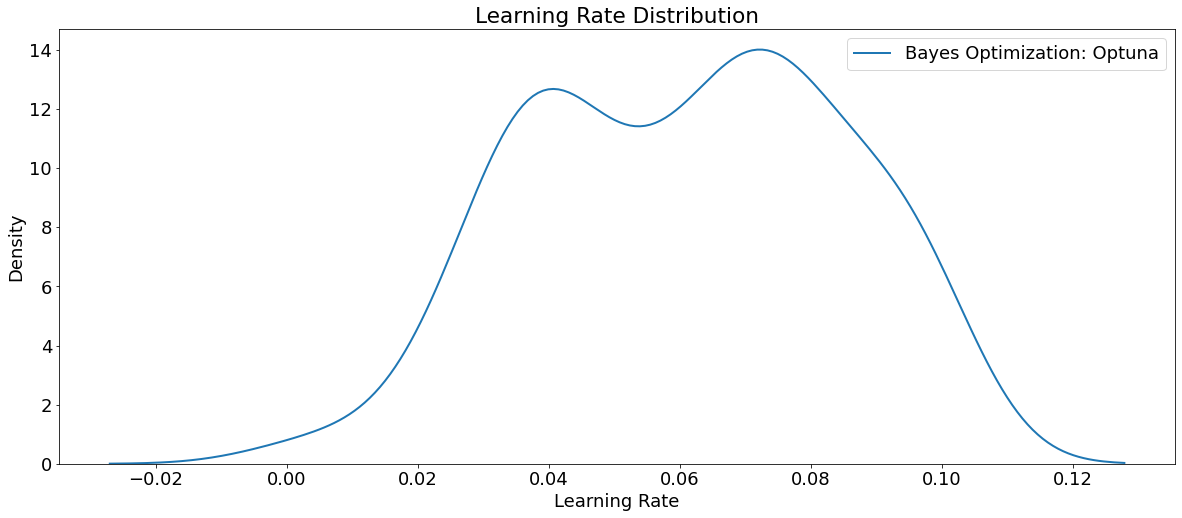

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); 
plt.title('Learning Rate Distribution');
plt.show()

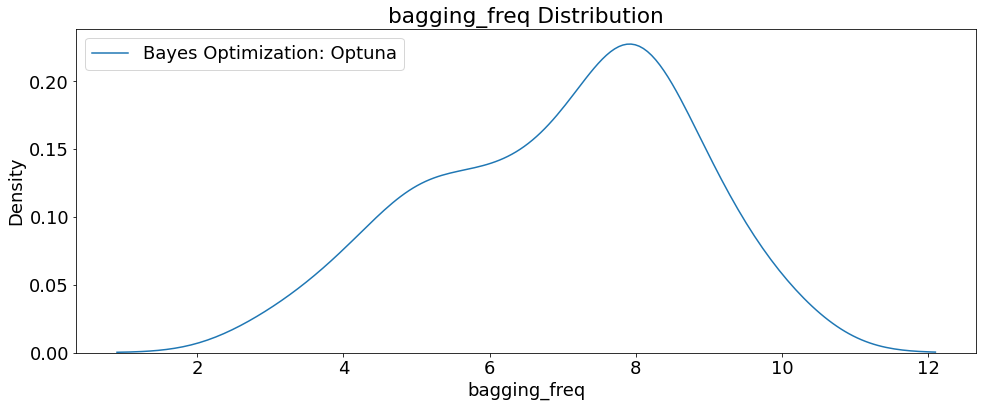

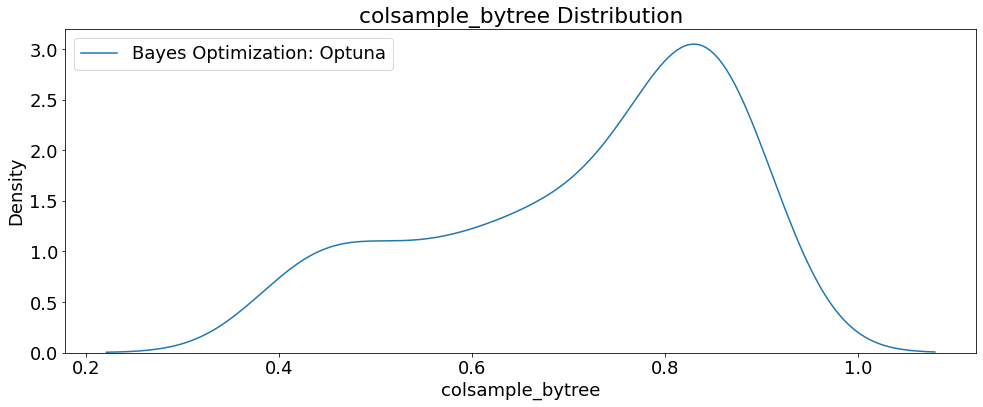

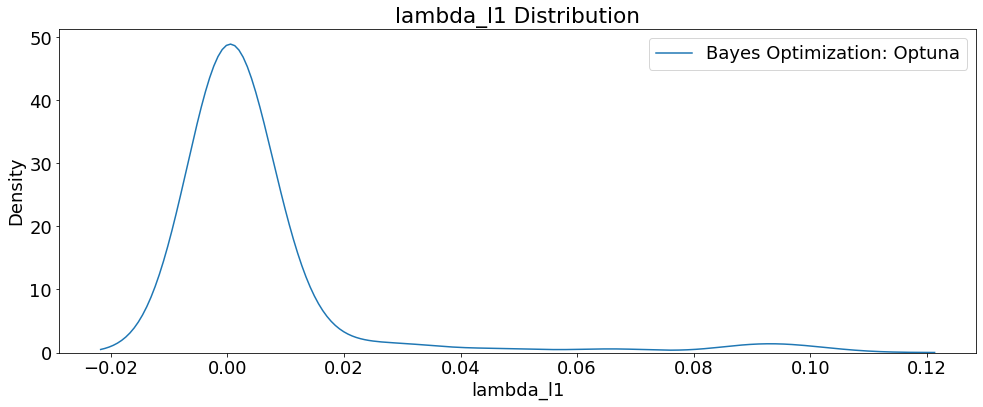

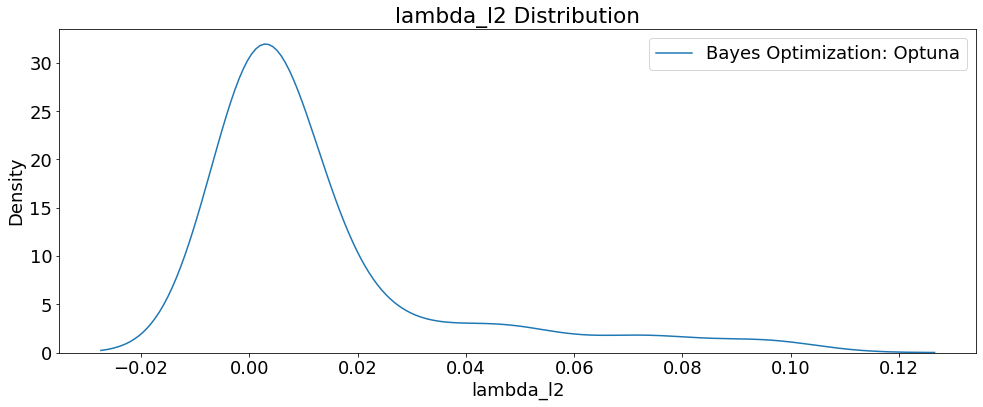

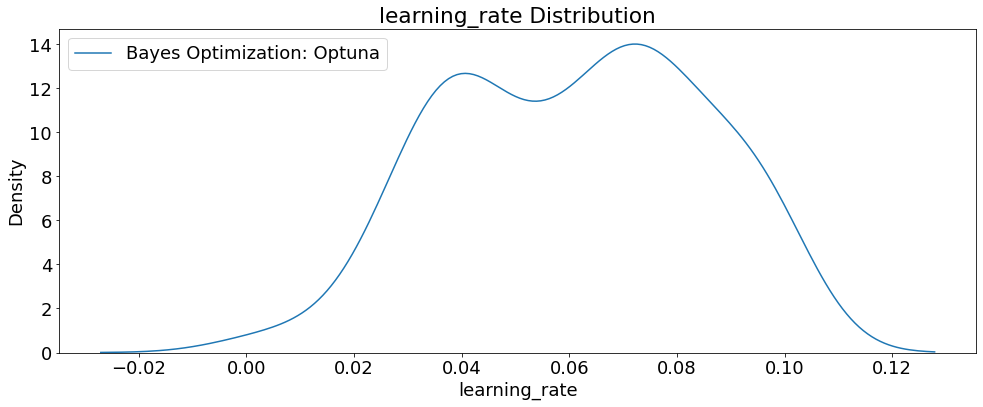

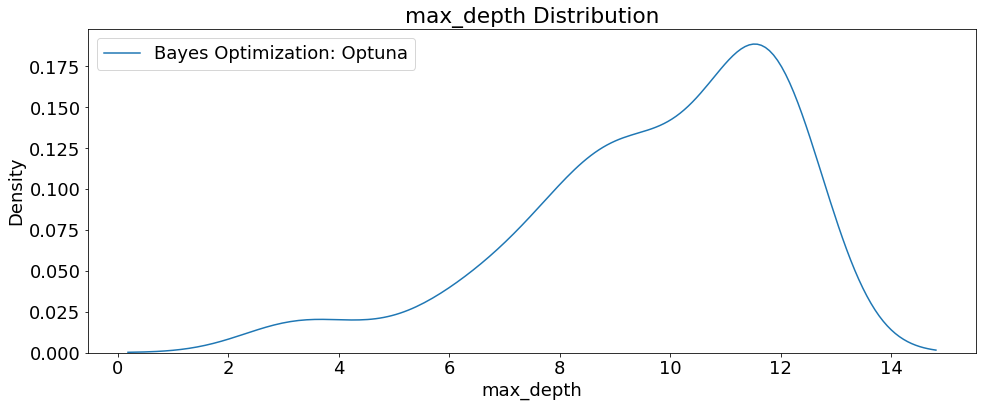

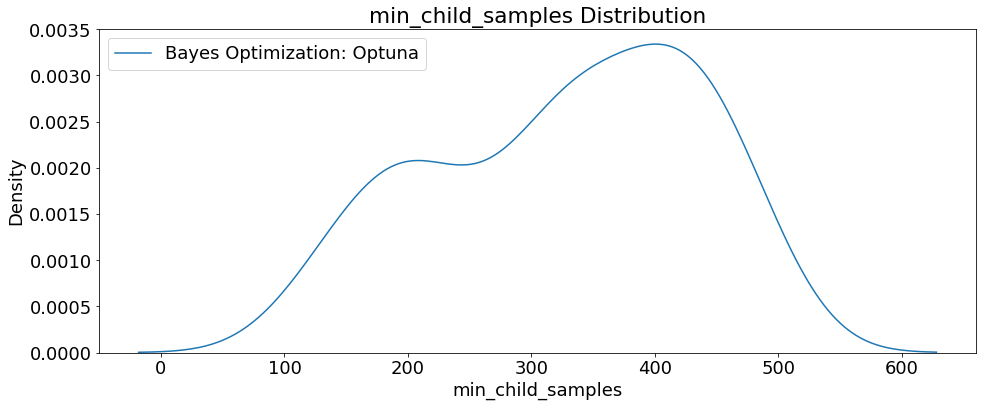

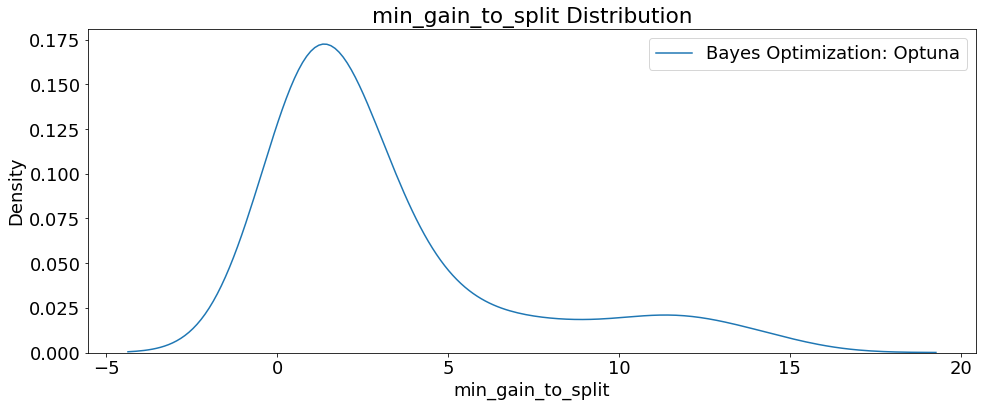

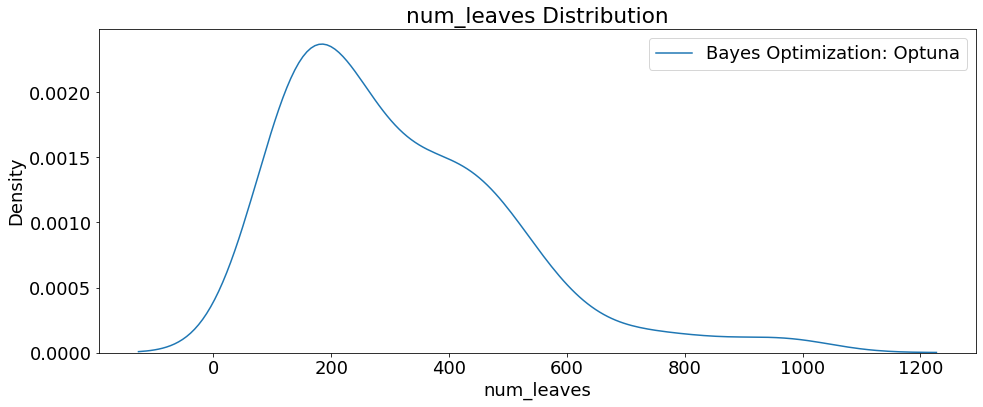

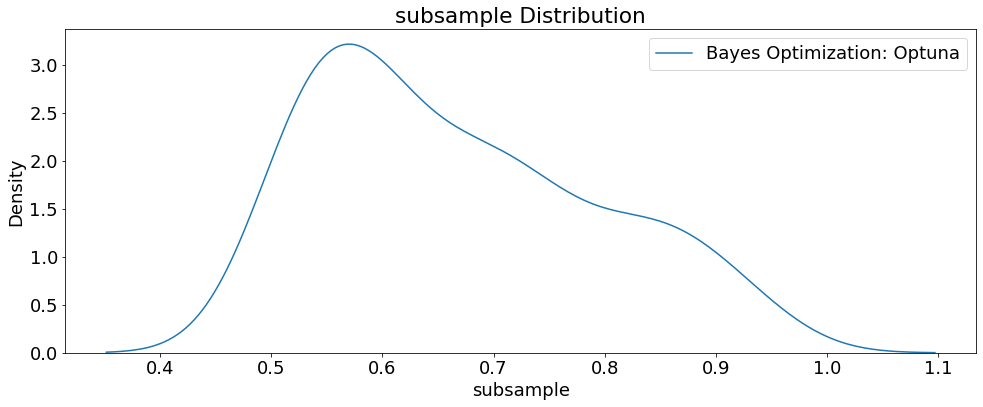

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

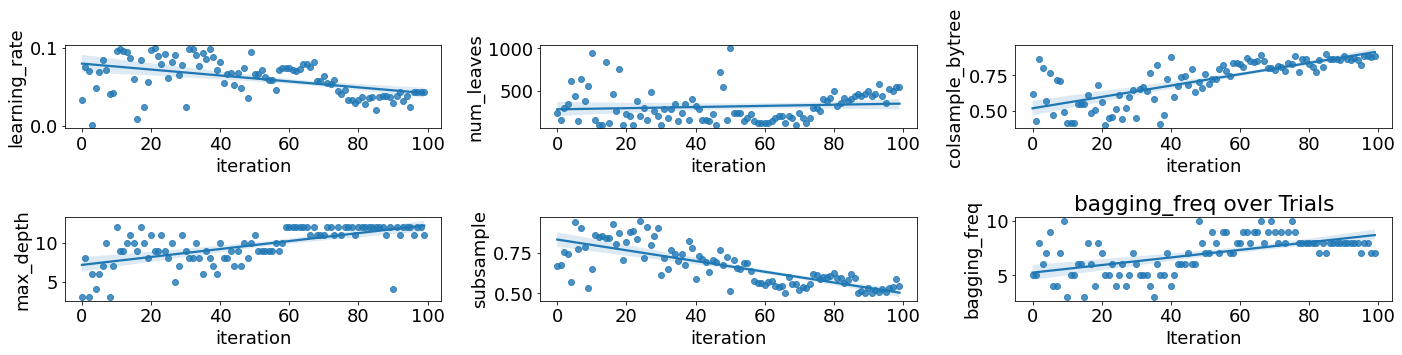

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(2, 3, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree', 
                         'max_depth', 'subsample', 'bagging_freq']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

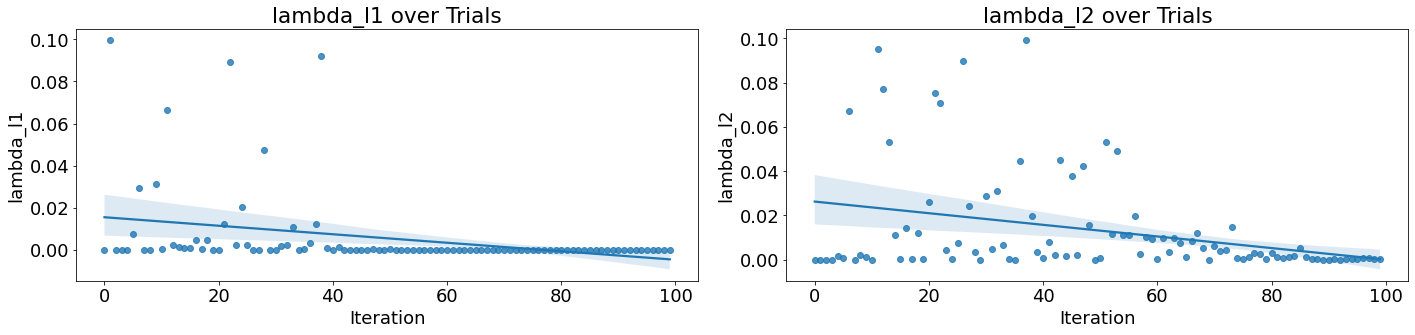

In [ ]:
# Scatterplot of regularization hyperparameters)
fig, axs = plt.subplots(1, 2, figsize=(20,5))
i = 0
for i, hpo in enumerate(['lambda_l1', 'lambda_l2']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['metric'] = 'binary_error'
params

{'n_estimators': 500,
 'learning_rate': 0.05448964351479689,
 'num_leaves': 180,
 'bagging_freq': 8,
 'subsample': 0.5368567399990583,
 'colsample_bytree': 0.8133982169962536,
 'max_depth': 12,
 'lambda_l1': 1.0441413071792594e-06,
 'lambda_l2': 0.0038951041088700184,
 'min_gain_to_split': 0.5350551160515755,
 'min_child_samples': 450,
 'random_state': 42,
 'metric': 'binary_error'}

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/lightGBM/SentimentPolarity/Model_PKL/

In [ ]:
# Set up label and features
label = df[['sentiment']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = LGBMClassifier(**params, verbosity=-1)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'lightGBM_HPO_Optuna_trials100_GPU_glove300d_sentPol.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM_HPO_Optuna_trials100_GPU_glove300d_sentPol.pkl')
# print(model)
# =============================================================================

[LightGBM] [Warning] lambda_l2 is set=0.0038951041088700184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038951041088700184
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l1 is set=1.0441413071792594e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0441413071792594e-06
[LightGBM] [Warning] min_gain_to_split is set=0.5350551160515755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5350551160515755


In [ ]:
print('Results from lightGBM HPO Optuna 100 glove300d GPU Sentiment Polarity trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from lightGBM HPO Optuna 100 glove300d GPU Sentiment Polarity trials:


Classification Report: Train
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    331949
           1       0.97      0.97      0.97    331950

    accuracy                           0.97    663899
   macro avg       0.97      0.97      0.97    663899
weighted avg       0.97      0.97      0.97    663899



Confusion matrix: Train
[[323296   8653]
 [  9720 322230]]


Classification Report: Test
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     82988
           1       0.96      0.96      0.96     82987

    accuracy                           0.96    165975
   macro avg       0.96      0.96      0.96    165975
weighted avg       0.96      0.96      0.96    165975



Confusion matrix: Test
[[79695  3293]
 [ 3521 79466]]


Accuracy score: train: 0.972, test: 0.959
Precision score: train: 0.974, test: 0.960
Rec

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.95895 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    71
logloss                                0.111598
datetime_start       2022-09-10 06:27:49.234098
datetime_complete    2022-09-10 06:29:43.841268
duration                 0 days 00:01:54.607170
bagging_freq                                  8
colsample_bytree                       0.813398
lambda_l1                              0.000001
lambda_l2                              0.003895
learning_rate                           0.05449
max_depth                                    12
min_child_samples                           450
min_gain_to_split                      0.535055
n_estimators                                500
num_leaves                                  180
subsample                              0.536857
state                                  COMPLETE
Name: 0, dtype: object
